# Goal of the project
The goal is to create a music playlist based on a piece of input text. This was inspired by my desire to have a music accompaniment for board games. However, the experience would be enhanced by choosing music that matched the theme of the board game. This could obviously be expanded to setting a playlist based on any piece of input text, and so I've tested it on descriptions of movies, TV shows, and books as well.

The first step in finding a playlist is picking a mood. Here I build a model that predicts a genre from the string. This is trained by a corpus of genre-labeled songs. 

Next, within that genre I select a set of songs that share similar words. These are selected by finding the closest neighbors from a TFIDF vectorizer (normalizes by total document frequency).

# Obtaining data
I first needed to get a database of song encompassing a relatively large range of styles. I chose 50 artists from three genres (Rock, Country, and Hip-Hop/R&B) based on Billboard.com 2018 year-end top artists lists. I scraped song lyrics (up to 100 songs for each artist) from songlyrics.com using R. 

I needed to clean this data up a little bit by dropping duplicate songs (presumably from different albums) and alternative takes that had the same lyrics (remixes, live versions, etc.)

# Looking at the data
To get some idea of how these genres differ, I looked at word clouds that describe the frequency of words within each genre. This alone didn't give too much extra information (aside from more expletives present in the Hip-Hop category). 

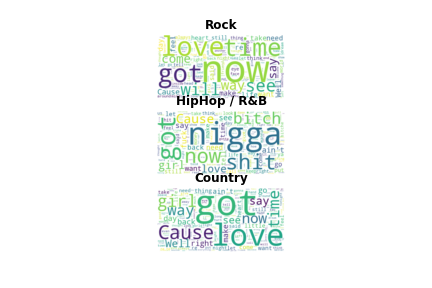

In [10]:
from IPython.display import Image
Image("img/lyric_clouds.png")

# Classifying strings
I fit a Multinomial Naive Bayes model to predict the three genres from a given string.

Artist and song accuracy are between 70-75%, but this may be able to be improved with further lyric cleaning.

I also wanted to get an idea of how well each artist was classified and song were classified in a more intuitive sense. Since I have three genres, I plotted on a triangle with three colors. For the artist and song assignments, the colored dots correspond to the actual category, and the location on the triangle shows how it was classified. Artist assignment was fairly accurate, and the model predicted with high certainty.

Song assignments are a little more scattered, and aren't particularly accurate at this point. One thing I notice here is that the model has some difficulty predicting between Rock and Country, and Country and Hip-Hop, but there aren't many instances of a point falling on the line between Rock and Hip-Hop. Interestingly, this seems to suggest that Country falls somewhere between Rock and Hip-Hop lyrically.

I used this classifer to categorize descriptions of movies, TV shows, books, and board games. This is the first step in creating playlists/soundtracks. There weren't many items classified in the Hip-Hop category, but the two that were are HBO shows about crime.  

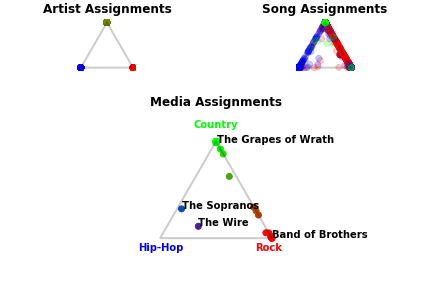

In [11]:
Image("img/genre-assignments.png")

# Creating a playlist
Import packages and lyric data

In [9]:

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
dataFilename = 'trigenre-lyrics-190519-dupremoved.csv'
song_info = pd.read_csv(dataFilename,encoding = "ISO-8859-1")

#Separate 
raw_rock_lyrics = song_info.loc[song_info.genre == 'rock'].loc[:,'lyrics']
raw_hiphop_lyrics = song_info.loc[song_info.genre == 'hip-hop'].loc[:,'lyrics']
raw_country_lyrics = song_info.loc[song_info.genre == 'country'].loc[:,'lyrics']



In [ ]:
#Vectorize text (don't actually need to use split data, but am now for future improvements)
X_train, X_test, y_train, y_test = train_test_split(song_info['lyrics'], song_info['genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#Train classifier 
clf = MultinomialNB().fit(X_train_tfidf, y_train)

To test this model I'll look at a synopsis for the film Forrest Gump (taken from an existing csv, used above).

In [19]:
query_name = 'forrest gump'
mediaFilename = 'media-descriptors.csv'
media_info = pd.read_csv(mediaFilename,encoding = "ISO-8859-1")
query_str = media_info.loc[media_info.name == query_name].iloc[0]['words']
#Print name and description
print(query_name)
print(query_str)
print('')
#Predict genre
print('Genre Classification:')
best_genre = clf.predict(count_vect.transform([query_str]))
print(best_genre)

forrest gump
On his first day of school, he meets a girl named Jenny, whose life is followed in parallel to Forrest's at times. Having discarded his leg braces, his ability to run at lightning speed gets him into college on a football scholarship. After his college graduation, he enlists in the army and is sent to Vietnam, where he makes fast friends with a black man named Bubba, who convinces Forrest to go into the shrimping business with him when the war is over. Later while on patrol, Forrest's platoon is attacked. Though Forrest rescues many of the men, Bubba is killed in action. Forrest is awarded the Congressional Medal of Honor for his heroism.

 Genre Classification:
['country']


In all honesty, this classification isn't terribly important because there's no right answer, but country seems about right for a movie about a boy that grows up in the south!

Next, we can look within the genre to pick the most similar songs, in terms of words used.

In [20]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the genre dataset to create normalized vectors
lyrics_plus=song_info.loc[:,['lyrics']][song_info.genre==best_genre[0]]
artist_index=song_info.loc[:,['artist','song']][song_info.genre==best_genre[0]]
#Add query to dataframe
next_num = lyrics_plus.index[-1]+1
lyrics_plus = lyrics_plus.append(pd.DataFrame({'lyrics':query_str},index=[next_num]))
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_plus.lyrics)

#Get the features of genre + query
features = tfidf_vectorizer.get_feature_names() 

#Define function to find and get artists and songs of nearest neighbors (in word vector space)
nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf_matrix)

def get_closest_neighs(t_str,art_index):
    row = lyrics_plus.index.get_loc(t_str)
    distances, indices = nbrs.kneighbors(tfidf_matrix.getrow(row))
    artist_similar = pd.Series(indices.flatten()[1:]).map(art_index.reset_index()['artist'])
    song_similar = pd.Series(indices.flatten()[1:]).map(art_index.reset_index()['song'])
    result = pd.DataFrame({'artist':artist_similar, 'name':song_similar})
    return result

print( get_closest_neighs(next_num,artist_index))


           artist                      name
0      tim-mcgraw          love_you_goodbye
1   rascal-flatts               bubbas_girl
2    trace-adkins            damn_you_bubba
3    brad-paisley          anything_like_me
4   reba-mcentire       i_know_how_he_feels
5    craig-morgan  the_ballad_of_mr_jenkins
6   reba-mcentire       the_christmas_guest
7  zac-brown-band                better_day
8   rodney-atkins        tell_a_country_boy


# Conclusions / Further work
This seems like a good start. The hardest work here might be obtaining a good dataset of songs, with well-defined genres. There are a lot of country-adjacent songs in the rock category from artists like Lynyrd Skynrd. With a larger dataset, I'd be better able to define these sub-genres, but the labeling will take work. 

I'll also need to do more work cleaning the lyrics and removing things that appear in a subset of the songs, like album titles and singers.

In the short term, I would like to add some sentiment analysis to further classify the playlists into positive or negative emotions. In the long term I'd like to add features from the music itself (loudness, key, etc) to aid in further subclassification (and allow for instrumental music).
